In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from icecream import ic
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm import trange

import torch
from torch import nn
import torch.nn.functional as F

from mech_int_othelloGPT.tl_othello_utils import (
    stoi,
    ALPHA,
    COLUMNS,
    STARTING_SQUARES,
    load_hooked_model,
)
from mech_int_othelloGPT.utils import set_seed
from mech_int_othelloGPT.board_probe import (
    train as train_linear,
    evaluate
)
from mech_int_othelloGPT.mid_probe import (
    train as train_mid,
    evaluate as evaluate_mid
)
from mech_int_othelloGPT.intervene import intervene_layer_hooks

100%|██████████| 1/1 [00:00<00:00, 101.66it/s]


Dataset created has 1 sequences, 61 unique words.


In [3]:
set_seed(24601)

PAPER_CODE_DIR = Path("mech_int_othelloGPT")
PROBE_DIR = PAPER_CODE_DIR / "mech_int" / "probes"
NEW_PROBE_DIR = Path("new_probes")
DATA_DIR = PAPER_CODE_DIR / "data"

MID_PROBE_DIR = NEW_PROBE_DIR / "mid"
LINEAR_PROBE_DIR = PROBE_DIR / "linear"
FLIPPED_PROBE_DIR = PROBE_DIR / "flipped"

ALL_SQUARES = [s for s in range(64)]
NON_STARTING_SQUARES = [s for s in ALL_SQUARES if s not in STARTING_SQUARES]

In [17]:
def get_interventions(pre_probe_dir, post_probe_dir):
    """Get interventions for bottom N and top N layers."""
    interventions = []
    layer_hooks = []
    layer_hook_history = []


    def get_new_interventions():
        layer_hook_history.append(layer_hooks.copy())
        return intervene_layer_hooks(
            pre_probe_dir,
            post_probe_dir,
            layer_hooks,
            device="mps",
        )
    

    pbar = trange(8)
    for top_layer in pbar:
        layer_hooks.append((top_layer, "resid_mid"))
        interventions.append(get_new_interventions())
        layer_hooks.append((top_layer, "resid_post"))
        interventions.append(get_new_interventions())
    
    pbar = trange(8)
    while layer_hooks:
        layer_hooks.pop(0)
        interventions.append(get_new_interventions())
        layer_hooks.pop(0)
        interventions.append(get_new_interventions())
        pbar.update(1)

    
    # intervention errors, null errors, layer_hooks
    return [x[0] for x in interventions], [x[1] for x in interventions], layer_hook_history


errs, null, layer_hook_history = get_interventions(
    MID_PROBE_DIR,
    LINEAR_PROBE_DIR
)

100%|██████████| 1/1 [00:00<00:00, 97.96it/s]


Dataset created has 1 sequences, 61 unique words.


100%|██████████| 8/8 [25:10<00:00, 188.86s/it]


In [19]:
errs, null, layer_hook_history

([2.675324675324675,
  2.4075924075924076,
  2.255744255744256,
  1.4825174825174825,
  0.9270729270729271,
  0.4835164835164835,
  0.5034965034965035,
  0.4195804195804196,
  0.5194805194805194,
  0.5954045954045954,
  0.7652347652347652,
  0.8371628371628371,
  0.9210789210789211,
  0.9330669330669331,
  0.9250749250749251,
  0.929070929070929,
  0.47952047952047955,
  0.25374625374625376,
  0.1838161838161838,
  0.13586413586413587,
  0.07992007992007992,
  0.057942057942057944,
  0.025974025974025976,
  0.023976023976023976,
  0.08391608391608392,
  0.7272727272727273,
  1.6023976023976023,
  2.143856143856144,
  2.5134865134865136,
  2.5334665334665334,
  2.5534465534465536,
  2.723276723276723],
 [2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276

In [23]:
# Get into form for plotting
errs_mid_rev = errs[:-1:2]
errs_post_rev = errs[1:-1:2]

# Also check null errors are all the same (don't have to fix order)
assert all([x == null_mid[0] for x in null_mid])
assert all([x == null_mid[0] for x in null_post])

NameError: name 'null_post' is not defined

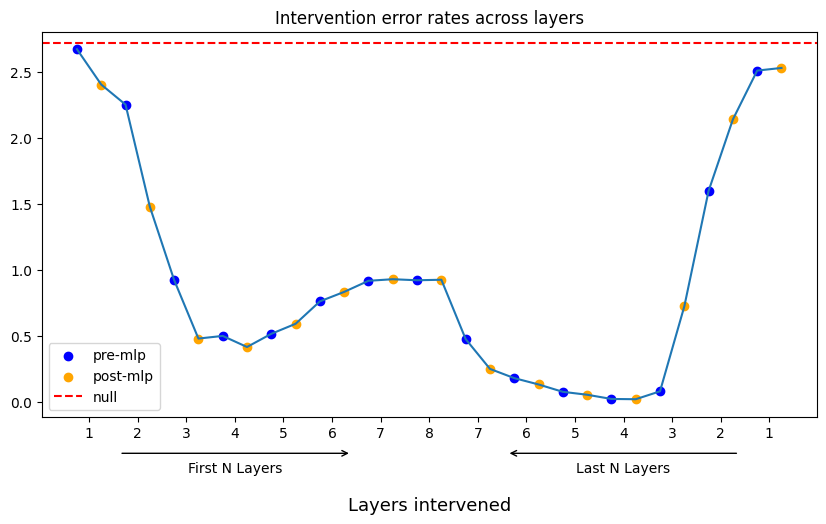

In [24]:
# Plot interventions
def plot_intervention_errs(errs_mid, errs_post, err_null):
    """Plot interleaved error rates for mid and post probes."""
    errs_all = [err.item() for pair in zip(errs_mid, errs_post) for err in pair]
    x_labels = np.array(list(range(8)) + list(range(6, -1, -1))) + 1

    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    sns.lineplot(x=range(len(errs_all)), y=errs_all, ax=axs)
    axs.set_title("Intervention error rates across layers")
    axs.set_xticks(2 * np.arange(len(errs_all)//2) + 0.5)
    axs.set_xticklabels(x_labels)
    axs.set_xlabel("Layers intervened", labelpad=40, fontsize=13)

    # Plot scatter points coloured by mid or post
    pre_xs = [i for i in range(len(errs_all)) if i % 2 == 0]
    pre_ys = [errs_all[i] for i in range(len(errs_all)) if i % 2 == 0]
    axs.scatter(pre_xs, pre_ys, c="blue", label="pre-mlp")
    post_xs = [i for i in range(len(errs_all)) if i % 2 == 1]
    post_ys = [errs_all[i] for i in range(len(errs_all)) if i % 2 == 1]
    axs.scatter(post_xs, post_ys, c="orange", label="post-mlp")

    # Plot null error rate as dashed line
    axs.axhline(err_null, c="red", linestyle="--", label="null")

    # Adjust the positioning and size of the arrows and text
    y = -0.095
    axs.annotate('',
                xy=(0.1, y),
                xycoords='axes fraction',
                xytext=(0.4, y), 
                arrowprops=dict(arrowstyle="<-", color='k'))
    axs.annotate('First N Layers',
                 xy=(0.3, y-0.15),
                 xycoords='axes fraction', 
                 xytext=(0.25, y-0.04),
                 ha='center',
                 va='center')
    axs.annotate('',
                xy=(0.6, y),
                xycoords='axes fraction',
                xytext=(0.9, y), 
                arrowprops=dict(arrowstyle="->", color='k'))
    axs.annotate('Last N Layers',
                 xy=(0.7, y-0.15),
                 xycoords='axes fraction', 
                 xytext=(0.75, y-0.04),
                 ha='center',
                 va='center')

    plt.legend()
    plt.show()

plot_intervention_errs(errs_mid_rev, errs_post_rev, null[0])